In [15]:
#@formatter:off
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,  MinMaxScaler
from sklearn.svm import SVC


pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
%matplotlib inline
sns.set_theme(style='whitegrid')
#@formatter:on

In [16]:
def get_tags(column, tags):
    column.fillna('', inplace=True)
    output = pd.Series(index=column.index, dtype=object)
    for tag in tags:
        output[column.str.contains(tag)] = tag
    return output


def extend_feature_names(origin_column, new_features):
    if isinstance(new_features, str):
        return [origin_column + '_' + str(new_features)]
    else:
        return [origin_column + '_' + str(feature) for feature in new_features]


def extend_intervals_borders(intervals):
    leftmost = pd.Interval(-np.inf, intervals[0].right)
    rightmost = pd.Interval(intervals[-1].left, np.inf)
    return pd.IntervalIndex([leftmost, *intervals[1:-1], rightmost])


class TagAdder(BaseEstimator):
    def __init__(self, tags, column, tag_column, na_value=None):
        self.tags = tags
        self.column = column
        self.tag_column = tag_column
        self.na_value = na_value

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        df = df.copy()
        df[self.tag_column] = get_tags(df[self.column], self.tags)
        if self.na_value is not None:
            df[self.tag_column].fillna(self.na_value, inplace=True)
        return df


class DfBiner(BaseEstimator, TransformerMixin):
    def __init__(self, col_bins, quantile=False):
        self.col_bins = col_bins
        self.cut_func = pd.qcut if quantile else pd.cut
        self.col_bins_fitted = {}

    def fit(self, df, y=None):
        for col, bins in self.col_bins.items():
            self.col_bins_fitted[col] = extend_intervals_borders(
                self.cut_func(df[col], bins, duplicates='drop').dtype.categories)
        return self

    def transform(self, df, y=None):
        df = df.copy()
        for col, bins in self.col_bins_fitted.items():
            df[col] = pd.cut(df[col], bins).astype(str)
        return df


class TitleReplacer(BaseEstimator):
    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        df = df.copy()
        df['Title'] = df.apply(self.__replace_title, axis=1)
        return df

    def __replace_title(self, row):
        title = row['Title']
        if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Countess', 'Mme']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms']:
            return 'Miss'
        elif title == 'Dr':
            if row['Sex'] == 'Male':
                return 'Mr'
            else:
                return 'Mrs'
        else:
            return title


class TitanicFeatureFixer(BaseEstimator):
    def __init__(self, remove_list):
        self.remove_list = remove_list

    def fit(self, df, y=None):
        return self

    # TODO add survival rate
    def transform(self, df, y=None):
        df = df.copy()
        df['Embarked'].fillna('S', inplace=True)
        df['Deck'].replace(['A', 'B', 'C', 'T'], 'ABC', inplace=True)
        df['Deck'].replace(['D', 'E'], 'DE', inplace=True)
        df['Deck'].replace(['F', 'G'], 'FG', inplace=True)
        grouped_median_age_vals = df.groupby(['Sex', 'Pclass'])['Age'].median()
        for sex in df.Sex.unique():
            for pclass in df.Pclass.unique():
                df.loc[(df.Pclass == pclass) & (df.Sex == sex) & (df.Age.isna()), 'Age'] =\
                    grouped_median_age_vals.loc[(sex, pclass)]
        na_fare_pas = df.loc[df.Fare.isna()]
        df['Fare'].fillna(
            df.groupby(['SibSp', 'Parch', 'Pclass'])['Fare'].median()
                .loc[(na_fare_pas.SibSp, na_fare_pas.Parch, na_fare_pas.Pclass)].values[0],
            inplace=True)
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
        df['FamilySize'].replace([1], 'Alone', inplace=True)
        df['FamilySize'].replace([2, 3, 4], 'Small', inplace=True)
        df['FamilySize'].replace([5, 6], 'Medium', inplace=True)
        df['FamilySize'].replace([7, 8, 11], 'Large', inplace=True)
        df['Family'] = df['Name']\
            .str.replace('\(|\)', '', regex=True).str.split(',',expand=True)[0]
        df['TicketFrequency'] = df.groupby('Ticket')['Ticket'].transform('count')
        df['IsMarried'] = 0
        df.loc[df['Title'] == 'Mrs', 'IsMarried'] = 1
        # df['AgeClass'] = df['Age'] * df['Pclass']
        # df['FarePerPerson'] = df['Fare'] / df['FamilySize']
        # df['isAlone'] = 0
        # df.loc[df['FamilySize'] == 1, 'isAlone'] = 1
        df.drop(self.remove_list, axis=1, inplace=True)
        return df


class AutoEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, extra_cat_features=()):
        self.extra_cat_features = extra_cat_features
        self.__clean_attributes()

    def fit(self, df, y=None):
        self.__init_attributes(df)
        self.categories_.extend(self.__numeric.copy())
        for col in self.__binary:
            encoder = OrdinalEncoder()
            encoder.fit(np.c_[df[col]])
            self.categories_.extend(extend_feature_names(col, encoder.categories_[0][0]))
            self.__encoders.append(encoder)
        for col in self.__categorical:
            encoder = OneHotEncoder(sparse=False)
            encoder.fit(np.c_[df[col]])
            extended_features = extend_feature_names(col, encoder.categories_[0])
            self.categories_.extend(extended_features)
            self.__encoders.append(encoder)
        return self

    def transform(self, df, y=None):
        features = [df[self.__numeric].to_numpy()]
        for col, enc in zip(self.__binary + self.__categorical, self.__encoders):
            feature = enc.transform(np.c_[df[col]])
            features.append(feature)
        return np.concatenate([*features], axis=1)

    def __init_attributes(self, df):
        self.__clean_attributes()
        for col in df.columns:
            print(col)
            if np.issubdtype(df[col], np.number) and col not in self.extra_cat_features:
                self.__numeric.append(col)
            else:
                if len(df[col].unique()) == 2:
                    self.__binary.append(col)
                else:
                    self.__categorical.append(col)

    def __clean_attributes(self):
        self.__numeric = []
        self.__binary = []
        self.__categorical = []
        self.__encoders = []
        self.categories_ = []

In [17]:
train_df = pd.read_csv('data/titanic_train.csv')
test_df = pd.read_csv('data/titanic_test.csv')
y_train = train_df.Survived.to_numpy()
train_df.drop(columns='Survived', inplace=True)
train_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
titles = train_df['Name'].str.extract('([A-Za-z]+)\.').loc[:, 0].tolist()
print(titles[:10])

decks = train_df.Cabin.str[0].unique()[1:]
print(decks[:10])

['Mr', 'Mrs', 'Miss', 'Mrs', 'Mr', 'Mr', 'Mr', 'Master', 'Mrs', 'Mrs']
['C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


In [19]:
full_pipeline = Pipeline([
    ('title_tagger', TagAdder(titles, 'Name', 'Title')),
    ('title_replacer', TitleReplacer()),
    ('deck_tagger', TagAdder(decks, 'Cabin', 'Deck', 'M')),
    ('feature_fixer', TitanicFeatureFixer(['Name', 'Ticket', 'SibSp', 'Parch', 'Cabin', 'PassengerId'])),
    ('dfbiner', DfBiner({'Fare': 13, 'Age': 10}, quantile=True)),
    ('auto_encoder', AutoEncoder(extra_cat_features=['Pclass'])),
    ('minmax_scaler', MinMaxScaler()),  # TODO try another encoder
])

all_df = pd.concat([train_df, test_df])
X_all = full_pipeline.fit_transform(all_df)
X_train, X_test = X_all[:train_df.shape[0]], X_all[train_df.shape[0]:]
print(full_pipeline['auto_encoder'].categories_)
# X_all

Pclass
Sex
Age
Fare
Embarked
Title
Deck
FamilySize
Family
TicketFrequency
IsMarried
['TicketFrequency', 'IsMarried', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age_(-inf, 16.0]', 'Age_(16.0, 21.0]', 'Age_(21.0, 22.0]', 'Age_(22.0, 25.0]', 'Age_(25.0, 26.0]', 'Age_(26.0, 29.5]', 'Age_(29.5, 34.0]', 'Age_(34.0, 40.0]', 'Age_(40.0, 48.0]', 'Age_(48.0, inf]', 'Fare_(-inf, 7.25]', 'Fare_(10.5, 13.0]', 'Fare_(13.0, 15.742]', 'Fare_(15.742, 23.25]', 'Fare_(23.25, 26.55]', 'Fare_(26.55, 34.075]', 'Fare_(34.075, 56.496]', 'Fare_(56.496, 83.475]', 'Fare_(7.25, 7.75]', 'Fare_(7.75, 7.896]', 'Fare_(7.896, 8.05]', 'Fare_(8.05, 10.5]', 'Fare_(83.475, inf]', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Deck_ABC', 'Deck_DE', 'Deck_FG', 'Deck_M', 'FamilySize_Alone', 'FamilySize_Large', 'FamilySize_Medium', 'FamilySize_Small', 'Family_Abbing', 'Family_Abbott', 'Family_Abelseth', 'Family_Abelson', 'Family_Abrahamsson', 'Family_Abrahim', 'Family

{'whiskers': [<matplotlib.lines.Line2D at 0x7f50e0592c10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f50e059a370>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f50e0592880>,
 'medians': [<matplotlib.lines.Line2D at 0x7f50e059aa90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f50e059ae20>,
 'means': []}

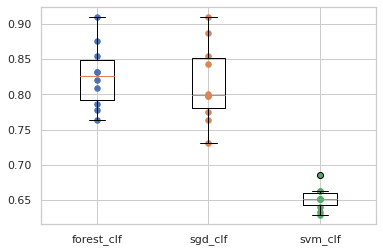

In [20]:
forest_clf = RandomForestClassifier(random_state=228)
sgd_clf = SGDClassifier(random_state=228)
svm_clf = SVC(gamma='auto', random_state=228)

cv = 10
models = [forest_clf, sgd_clf, svm_clf]
scores = [cross_val_score(model, X_train, y_train.ravel(), cv=cv, n_jobs=-1) for model in models]
for i in range(len(scores)):
    plt.scatter([i + 1] * cv, scores[i], s=30)
plt.boxplot(scores, labels=['forest_clf', 'sgd_clf', 'svm_clf'])

In [21]:
forest_clf = RandomForestClassifier(random_state=228, n_jobs=-1, verbose=1)
param_grid = [{
    'n_estimators': [1000, 1300, 1600],
    'max_depth': [3,5,7],
    'min_samples_split': [4,5,6],
    'min_samples_leaf': [5,6,7]
}]
grid_search = GridSearchCV(forest_clf, param_grid, cv=3)
grid_search.fit(X_train, y_train)

In [22]:
cvres = grid_search.cv_results_
for accuracy, params in zip(cvres['mean_test_score'], cvres['params']):
    print(accuracy, params)
print(grid_search.best_estimator_)

In [ ]:
# N = 5
# oob = 0
# probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
# importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
# fprs, tprs, scores = [], [], []
#
# skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)
#
# for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
#     print('Fold {}\n'.format(fold))
#
#     # Fitting the model
#     leaderboard_model.fit(X_train[trn_idx], y_train[trn_idx])
#
#     # Computing Train AUC score
#     trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], leaderboard_model.predict_proba(X_train[trn_idx])[:, 1])
#     trn_auc_score = auc(trn_fpr, trn_tpr)
#     # Computing Validation AUC score
#     val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], leaderboard_model.predict_proba(X_train[val_idx])[:, 1])
#     val_auc_score = auc(val_fpr, val_tpr)
#
#     scores.append((trn_auc_score, val_auc_score))
#     fprs.append(val_fpr)
#     tprs.append(val_tpr)
#
#     # X_test probabilities
#     probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 0]
#     probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 1]
#     importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_
#
#     oob += leaderboard_model.oob_score_ / N
#     print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_model.oob_score_))
#
# print('Average OOB Score: {}'.format(oob))

In [23]:
forest_clf = RandomForestClassifier(criterion='gini', n_estimators=1100, max_depth=5, min_samples_split=4, min_samples_leaf=5, max_features='auto', oob_score=True, random_state=228, n_jobs=-1, verbose=1)
forest_clf.fit(X_train, y_train)
prediction = forest_clf.predict(X_test)
submission = pd.DataFrame({'Survived': prediction}, index=test_df['PassengerId'])
print(submission)
submission.to_csv('data/submission.csv')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s


             Survived
PassengerId          
892                 0
893                 0
894                 0
895                 0
896                 0
...               ...
1305                0
1306                1
1307                0
1308                0
1309                0

[418 rows x 1 columns]


[Parallel(n_jobs=12)]: Done 1100 out of 1100 | elapsed:    0.2s finished
